
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [2]:
import pandas as pd

import numpy as np
## Load the data into a DataFrame
liquor = pd.read_csv('../../../../Iowa_Liquor_sales_sample_10pct.csv')[['Store Number',
               'Date',
               'City',
               'Zip Code',
               'County Number',
               'County',
               'Bottle Volume (ml)', 
               'State Bottle Cost', 
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)', 
               'Volume Sold (Liters)', 
               'Volume Sold (Gallons)']]


In [3]:
## Make necessary column modifications

## Transform the dates
liquor["Date"] = pd.to_datetime(liquor["Date"], format="%m/%d/%Y")

## I'm creating functions for a few different things
## that I'll be able to reuse when I import the full dataset
def  clean_columns(table):
    table.columns = [x.replace(' ', '_') for x in table.columns]
    table.columns = [x.replace(')', '') for x in table.columns]
    table.columns = [x.replace('(', '') for x in table.columns]
    table.columns = [x.lower()  for x in table.columns]  
    table.city = liquor.city.str.upper()   #capitalize all cities and counties
    table.county = table.county.str.upper()
    ## remove dollar sign from monetary columns and convert to float
    for column in ('sale_dollars', 'state_bottle_retail', 'state_bottle_cost'):
        table[column] = table[column].str.replace('$','').astype(np.float64)
    ## convert to float
    table['bottles_sold'] = table['bottles_sold'].astype(np.float64)

clean_columns(liquor)

In [4]:
## check: missing values, dtypes, df shape, describe, unique values, duplicates

def eda(dataframe):
    
    print "missing values \n", dataframe.isnull().sum()## count number of null values per column
    print ''
    print "dataframe types \n", dataframe.dtypes       ## list data type of each column
    print ''
    print "dataframe shape \n", dataframe.shape        ## rows by columns
    print ''
    print "dataframe describe \n", dataframe.describe()## stats -- mean, min, max, etc.. 
    print ''
    for item in dataframe:                             ## count number of unique values per column
        print item, '= ', dataframe[item].nunique()
    print ''
    print 'num duplicates:', dataframe.duplicated().sum()

# eda(liquor)

In [5]:
## As a result of the EDA function, 
## I will drop duplicates
## & fill in county names

## drop duplicate rows
liquor.drop_duplicates(inplace=True)
print 'num duplicates:', liquor.duplicated().sum()

## create a lookup table for all filled in counties, zip_codes
## that can be used to fill in any counties have a zip code but no name
county_lookup = liquor[['zip_code','county']][liquor.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)   # make sure there's only one of each county, drop dupes

## in addition to the lookup table, I'm using the file below
## to help fill in missing county names
iowa_zips = pd.read_csv('../../../../iowa_zips.csv')
iowa_zips.columns = [c.replace(' ', '_') for c in iowa_zips.columns]

## next cell will update county names

num duplicates: 0


In [6]:
## I spent a while trying to figure out how to update
## values in the pandas dataframe, but was very
## unsuccessful. I decided to run the updates using SQL instead.

## set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

## push dataframes into sql tables
liquor.to_sql('liquor', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)

## run updates to fill in county names by matching zip_codes to lookup data
q1 = 'update liquor set county = (select upper(county) from county_lookup where county_lookup.zip_code = liquor.zip_code) where county is null;'
q2 = 'update liquor set county = (select upper(County) from iowa_zips where iowa_zips.Zip_Code = liquor.zip_code) where county is null;'
conn.execute(q1)
conn.execute(q2)

## pull sql table back into a pandas df
liquor_sql = pd.read_sql_table('liquor',engine)

## close sql connection
conn.close()

eda(liquor_sql)

missing values 
index                     0
store_number              0
date                      0
city                      0
zip_code                  0
county_number          1061
county                    0
bottle_volume_ml          0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sale_dollars              0
volume_sold_liters        0
volume_sold_gallons       0
dtype: int64

dataframe types 
index                           int64
store_number                    int64
date                   datetime64[ns]
city                           object
zip_code                       object
county_number                 float64
county                         object
bottle_volume_ml                int64
state_bottle_cost             float64
state_bottle_retail           float64
bottles_sold                  float64
sale_dollars                  float64
volume_sold_liters            float64
volume_sold_gallons           float64
dtype: object

dataframe shap

In [7]:
## all are filled in!

## I'm happy with the quality of the data, so I'm
## going to go ahead and use the modified table
liquor = liquor_sql
liquor_sql = ''


## and now i'll export the data to be used for mapping in tableau
liquor.to_csv('../../../../Iowa_Liquor_sales_sample_10pct_CLEAN.csv') 


## because i'm neurotic, found coordinates for counties that couldn't be mapped in tableau
# https://dom.iowa.gov/document/iowa-county-codes-and-coordinates

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

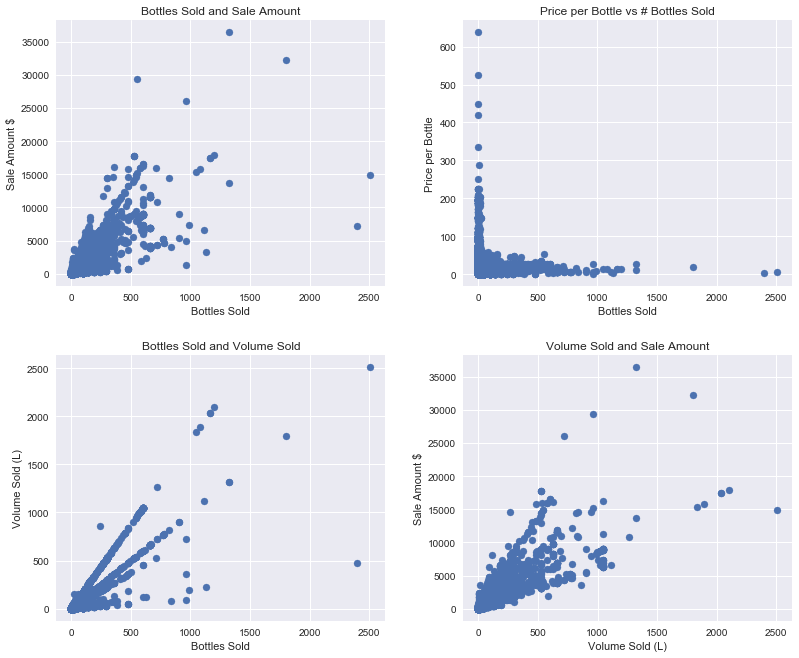

In [9]:
plt.close('all')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
plt.tight_layout(pad=5, w_pad=5, h_pad=5)

ax1.scatter(liquor.bottles_sold,liquor.sale_dollars)
ax1.set_xlabel('Bottles Sold')
ax1.set_ylabel('Sale Amount $')
ax1.set_title('Bottles Sold and Sale Amount')

ax2.scatter(liquor.bottles_sold,liquor.state_bottle_retail)
ax2.set_xlabel('Bottles Sold')
ax2.set_ylabel('Price per Bottle')
ax2.set_title('Price per Bottle vs # Bottles Sold')

ax3.scatter(liquor.bottles_sold,liquor.volume_sold_liters)
ax3.set_xlabel('Bottles Sold')
ax3.set_ylabel('Volume Sold (L)')
ax3.set_title('Bottles Sold and Volume Sold')

ax4.scatter(liquor.volume_sold_liters,liquor.sale_dollars)
ax4.set_xlabel('Volume Sold (L)')
ax4.set_ylabel('Sale Amount $')
ax4.set_title('Volume Sold and Sale Amount')

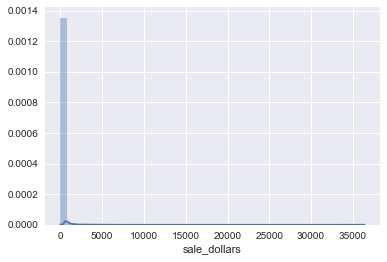

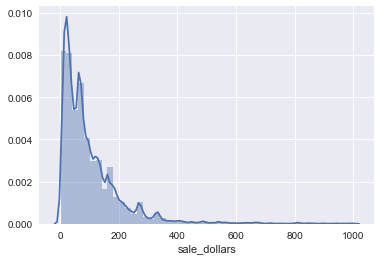

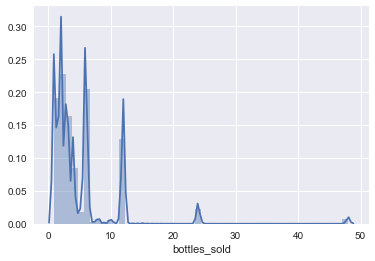

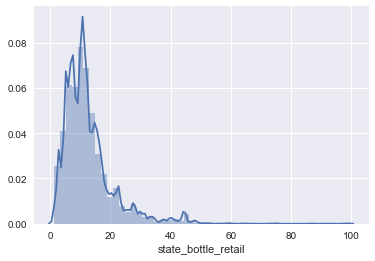

In [ ]:
sns.distplot(liquor['sale_dollars'])
plt.show()
sns.distplot(liquor['sale_dollars'][liquor.sale_dollars <1000])
plt.show()
sns.distplot(liquor['bottles_sold'][liquor.sale_dollars <100])
plt.show()
sns.distplot(liquor['state_bottle_retail'][liquor.sale_dollars <100])
plt.show()

In [ ]:
sns.heatmap(liquor[['sale_dollars','bottles_sold']], annot=True, fmt=".1f")

# Record your findings

Be sure to write out any observations from your exploratory analysis.


# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


In [1]:
liquor_by_store = liquor[['store_number',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail']].groupby(liquor.store_number).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum})

liquor_by_zip = liquor[['zip_code',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.zip_code).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                                   'store_number' : lambda x: x.nunique()})
liquor_by_city = liquor[['city',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.city).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                           'store_number' : lambda x: x.nunique()})
liquor_by_county = liquor[['county',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                          'store_number']].groupby(liquor.county).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                             'store_number' : lambda x: x.nunique()})


liquor_by_store['avg_price_per_bottle'] = liquor_by_store.sale_dollars / liquor_by_store.bottles_sold
liquor_by_zip['avg_price_per_bottle'] = liquor_by_zip.sale_dollars / liquor_by_zip.bottles_sold
liquor_by_city['avg_price_per_bottle'] = liquor_by_city.sale_dollars / liquor_by_city.bottles_sold
liquor_by_county['avg_price_per_bottle'] = liquor_by_county.sale_dollars / liquor_by_county.bottles_sold

liquor_by_zip['avg_sales_store'] = liquor_by_zip.sale_dollars / (liquor_by_zip.bottles_sold)
liquor_by_city['avg_sales_store'] = liquor_by_city.sale_dollars / (liquor_by_city.bottles_sold)
liquor_by_county['avg_sales_store'] = liquor_by_county.sale_dollars / (liquor_by_county.bottles_sold)

liquor_by_zip['avg_sales_store_plus1'] = liquor_by_zip.sale_dollars / (liquor_by_zip.bottles_sold + 1)
liquor_by_city['avg_sales_store_plus1'] = liquor_by_city.sale_dollars / (liquor_by_city.bottles_sold + 1)
liquor_by_county['avg_sales_store_plus1'] = liquor_by_county.sale_dollars / (liquor_by_county.bottles_sold + 1)

liquor_by_zip['delta_sales'] = liquor_by_zip.avg_sales_store - liquor_by_zip.avg_sales_store_plus1
liquor_by_city['delta_sales'] = liquor_by_city.avg_sales_store - liquor_by_city.avg_sales_store_plus1
liquor_by_county['delta_sales'] = liquor_by_county.avg_sales_store - liquor_by_county.avg_sales_store_plus1

NameError: name 'liquor' is not defined

# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

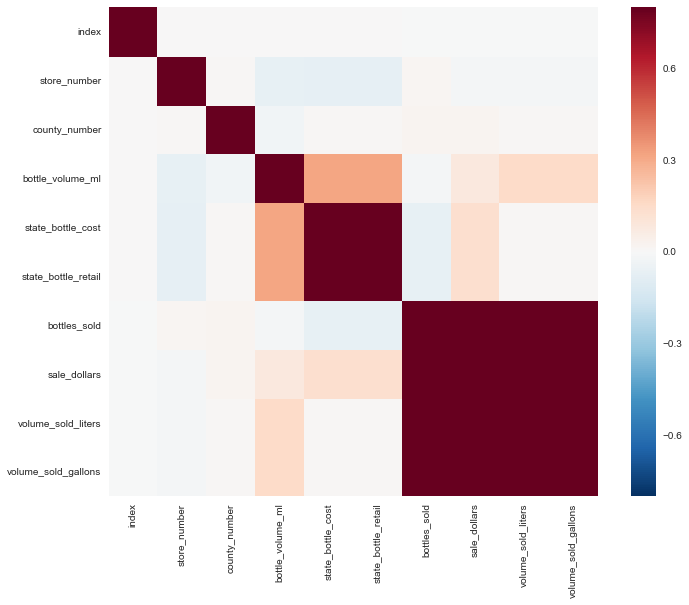

In [14]:
liquor_correlation = liquor.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(liquor_correlation, vmax=.8, square=True)


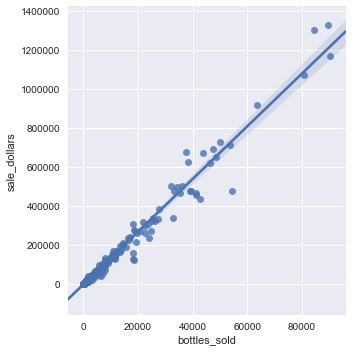

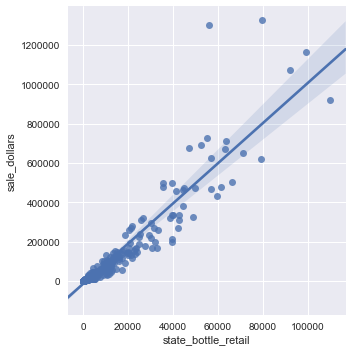

In [19]:
sns.lmplot(x="bottles_sold", y="sale_dollars", data=liquor_by_zip)
sns.lmplot(x="state_bottle_retail", y="sale_dollars", data=liquor_by_zip)

In [ ]:
sns.pairplot(liquor_by_store)

In [ ]:
sns.pairplot(liquor_by_zip)

In [ ]:
sns.pairplot(liquor_by_city)

In [ ]:
sns.pairplot(liquor_by_county)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [158]:
import statsmodels.formula.api as sm #import statsmodels

In [171]:
## Pull the top performing cities and zipcodes
X = liquor_by_zip[['bottles_sold','state_bottle_retail']]
y = liquor_by_zip['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model_zip = lm.fit(X,y)
print model_zip.score(X,y)
print model_zip.alpha_
print ''
liquor_by_zip['predictions'] = model_zip.predict(X)
print 'TOP PERFORMING ZIPS'
print liquor_by_zip[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

X = liquor_by_city[['bottles_sold','state_bottle_retail']]
y = liquor_by_city['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model_by_city = lm.fit(X,y)
print model_by_city.score(X,y)
print model_by_city.alpha_
print ''
liquor_by_city['predictions'] = model_by_city.predict(X)
print 'TOP PERFORMING CITIES'
print liquor_by_city[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

0.976802090947
6624280.86363

TOP PERFORMING ZIPS
          sale_dollars   predictions
zip_code                            
52402       1165695.97  1.209641e+06
50314       1324093.97  1.195702e+06
50320       1300314.63  1.122658e+06
52240       1070622.10  1.083018e+06
50010        918442.81  8.623744e+05
50703        478579.66  7.194809e+05
51501        709536.16  7.192885e+05
52807        729188.53  6.672085e+05
52001        651073.54  6.556334e+05
50311        689133.59  6.344812e+05
50613        621044.59  6.284729e+05
52722        670732.17  5.912843e+05
50317        433166.44  5.757151e+05
52404        466243.97  5.557931e+05
52804        456405.03  5.513286e+05
50702        474447.31  5.295751e+05
50401        476788.77  5.266456e+05
52241        625688.39  5.158448e+05
50266        674419.59  5.040662e+05
50265        503406.93  4.881370e+05
0.994565384735
9380074.72554

TOP PERFORMING CITIES
                 sale_dollars   predictions
city                                    

In [ ]:
from sklearn import linear_model


def liquor_50314_model(table):
    liquor_50314 = table[['store_number',features]][table.zip_code=='50314'].groupby(table.store_number).agg(aggs)
    X = liquor_50314[['bottles_sold','state_bottle_retail']]
    y = liquor_50314['sale_dollars']
    lm = linear_model.LassoCV(cv=5)
    return model_50314 = lm.fit(X,y)
    print '50314 model score = ', model_50314.score(X,y)
    print '50314 alpha =', model_50314.alpha_

print model_50314


liquor_50320 = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.zip_code=='50320'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
                                                                                                         
X = liquor_50320[['bottles_sold','state_bottle_retail']]
y = liquor_50320['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_50320 = lm.fit(X,y)
print '50320 model score =', model_50320.score(X,y)
print '50320 alpha =', model_50320.alpha_
print ''

liquor_desmoines = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.city=='DES MOINES'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X = liquor_desmoines[['bottles_sold','state_bottle_retail']]
y = liquor_desmoines['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_desmoines = lm.fit(X,y)
print 'Des Moines model score = ', model_desmoines.score(X,y)
print 'Des Moines alpha = ', model_desmoines.alpha_

In [172]:
X = liquor_by_store[['bottles_sold','state_bottle_retail']]
y = liquor_by_store['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model_by_store = lm.fit(X,y)
print model_by_store.score(X,y)
print model_by_store.alpha_
print ''
liquor_by_store['predictions'] = model_by_store.predict(X)
print 'TOP PERFORMING STORES'
liquor_by_store[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

0.974580804552
1344978.94051

TOP PERFORMING STORES


,sale_dollars,predictions
store_number,,
2633,1214597.96,1.176886e+06
4829,1078334.81,1.001242e+06
2512,527274.22,5.406449e+05
3385,506589.09,4.880430e+05
3420,402576.06,3.646401e+05
3952,390158.35,3.438443e+05
2670,279503.44,2.806037e+05
3354,295494.30,2.739709e+05
3773,297819.72,2.538914e+05


# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

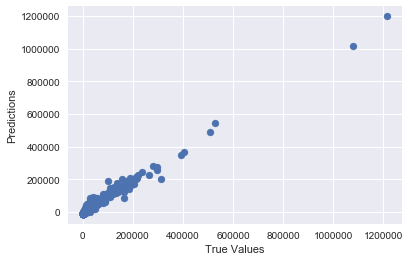

In [124]:
predictions = model_desmoines.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()

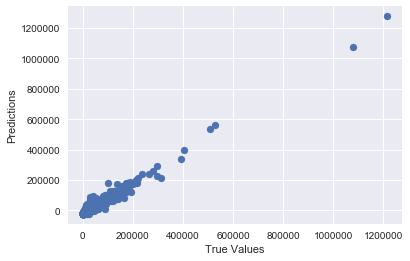

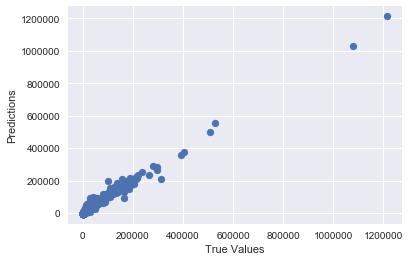

In [125]:
predictions = model_50314.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()


predictions = model_50320.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [27]:
## I'm now going to run through the full dataset and see how the models turn out. 
## This cell mimicks the operations performed on the reduced dataset

liquor_full = pd.read_csv('../../../../Iowa_Liquor_Sales_reduced.csv', dtype=str)[['Store Number',
               'City',
               'Zip Code',
               'County',
                'State Bottle Cost',
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)']]

clean_columns(liquor_full)
liquor_full.drop_duplicates(inplace=True)

# ## look into missing county_numbers and counties
county_lookup = liquor_full[['zip_code','county']][liquor_full.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)

# set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

# push dfs into sql tables
liquor_full.to_sql('liquor_full', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)

# run updates to fill in county names
conn.execute("update liquor_full set county = (select upper(county) from county_lookup where county_lookup.zip_code = liquor_full.zip_code) where county is null;")
conn.execute("update liquor_full set county = (select upper(County) from iowa_zips where iowa_zips.Zip_Code = liquor_full.zip_code) where county is null;")
# run updates to fill in county_numbers
# conn.execute("update liquor_full set county_number = (select county_number from county_lookup where county_lookup.zip_code = liquor_full.zip_code and county_lookup.county = liquor_full.county) where county_number is null;")
liquor_full_sql = pd.read_sql_table('liquor_full',engine)
# close sql connection
conn.close()

eda(liquor_full_sql)

liquor_full_sql['zip_code'][liquor_full_sql.county.isnull()==True]
liquor_full = liquor_full_sql


missing values 
index                       0
store_number                0
city                   562286
zip_code                    0
county                      0
state_bottle_cost           0
state_bottle_retail         0
bottles_sold                0
sale_dollars                0
dtype: int64

dataframe types 
index                    int64
store_number            object
city                    object
zip_code                object
county                  object
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold           float64
sale_dollars           float64
dtype: object

dataframe shape 
(825206, 9)

dataframe describe 
              index  state_bottle_cost  state_bottle_retail   bottles_sold  \
count  8.252060e+05      825206.000000        825206.000000  825206.000000   
mean   8.113669e+05          10.540008            15.833706      11.335191   
std    7.587644e+05          24.448563            36.672533      33.843053   
min    0.000000e+00        

In [ ]:
## Create separate dataframes for Des Moines, zipcodes 50314, 50320
features = 'store_number','bottles_sold','state_bottle_retail','sale_dollars'
aggs = {'bottles_sold': np.sum, 'state_bottle_retail' : np.sum, 'sale_dollars' : np.sum}
liquor_full_slim = liquor_full[[features]]

liquor_full_desmoines = liquor_full_slim[liquor_full.city=='DES MOINES'].groupby(liquor_full.store_number).agg(aggs)
X_full_desmoines = liquor_full_desmoines[['bottles_sold','state_bottle_retail']]
y_full_desmoines = liquor_full_desmoines['sale_dollars']

liquor_full_50314 = liquor_full_slim[liquor_full.zip_code=='50314'].groupby(liquor_full.store_number).agg(aggs)
X_full_50314 = liquor_full_50314[['bottles_sold','state_bottle_retail']]
y_full_50314 = liquor_full_50314['sale_dollars']

liquor_full_50320 = liquor_full_slim[liquor_full.zip_code=='50320'].groupby(liquor_full.store_number).agg(aggs)
X_full_50320 = liquor_full_50320[['bottles_sold','state_bottle_retail']]
y_full_50320 = liquor_full_50320['sale_dollars']


# run full data set for Des Moines and the two zipcodes on the models built on the reduced 10% data
print 'Des Moines score: ', model_desmoines.score(X_full_desmoines,y_full_desmoines)
print '50314 score: ', model_50314.score(X_full_50314,y_full_50314)
print '50320 score: ', model_50320.score(X_full_50320,y_full_50320)

In [173]:
## Look at the top performing stores and see if our two zipcodes are still there
liquor_full_by_store = liquor_full[[features]].groupby(liquor_full.store_number).agg(aggs)

X = liquor_full_by_store[['bottles_sold','state_bottle_retail']]
y = liquor_full_by_store['sale_dollars']

print model_by_store.score(X,y)
print model_by_store.alpha_
print ''
liquor_full_by_store['predictions'] = model_by_store.predict(X)
print 'TOP PERFORMING STORES'
liquor_full_by_store[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]


# results with the test data for top stores by performance:
# 2633	1214597.96	1.176886e+06
# 4829	1078334.81	1.001242e+06
# 2512	527274.22	5.406449e+05
# 3385	506589.09	4.880430e+05
# 3420	402576.06	3.646401e+05
# 3952	390158.35	3.438443e+05


# yay it matches the full set!! 

0.969850768125
1344978.94051

TOP PERFORMING STORES


,sale_dollars,predictions
store_number,,
2633,1.228265e+07,1.151508e+07
4829,1.108553e+07,1.015707e+07
2512,5.206377e+06,5.504713e+06
3385,4.759188e+06,4.592834e+06
3420,4.018415e+06,3.510523e+06
3952,3.768333e+06,3.387537e+06
2670,3.015680e+06,3.012344e+06
5102,2.557579e+06,2.796838e+06
3354,2.920467e+06,2.663687e+06


In [178]:

liquor_full_by_zip = liquor_full[['zip_code',features]].groupby(liquor_full.zip_code).agg(aggs)
liquor_full_by_city = liquor_full[['city',features]].groupby(liquor.city).agg(aggs)

X = liquor_full_by_zip[['bottles_sold','state_bottle_retail']]
y = liquor_full_by_zip['sale_dollars']

print model_zip.score(X,y)
print model_zip.alpha_
print ''
liquor_full_by_zip['predictions'] = model_zip.predict(X)
print 'TOP PERFORMING ZIPS'
print liquor_full_by_zip[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]


X = liquor_full_by_city[['bottles_sold','state_bottle_retail']]
y = liquor_full_by_city['sale_dollars']
print model_by_city.score(X,y)
print model_by_city.alpha_
print ''
liquor_full_by_city['predictions'] = model_by_city.predict(X)
print 'TOP PERFORMING CITIES'
print liquor_full_by_city[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]



0.976179985154
6624280.86363

TOP PERFORMING ZIPS
          sale_dollars   predictions
zip_code                            
50314     1.352982e+07  1.202532e+07
52402     1.125460e+07  1.170125e+07
52240     1.106181e+07  1.127014e+07
50320     1.312019e+07  1.103642e+07
50010     9.090596e+06  8.738001e+06
51501     6.998685e+06  7.330547e+06
50703     4.671745e+06  6.785124e+06
52807     7.504745e+06  6.732219e+06
52001     6.395593e+06  6.476215e+06
50613     6.257773e+06  6.342994e+06
50311     6.915971e+06  6.306530e+06
52722     6.632695e+06  5.963441e+06
50317     4.420838e+06  5.917337e+06
50702     5.339281e+06  5.732062e+06
52804     4.903297e+06  5.718866e+06
52404     4.780601e+06  5.680539e+06
52241     6.854789e+06  5.670584e+06
50401     4.842734e+06  5.295362e+06
50266     7.214257e+06  5.265494e+06
50265     5.183613e+06  5.104059e+06
0.994125197863
9380074.72554

TOP PERFORMING CITIES
                 sale_dollars   predictions
city                                    

Limitations: We don't actually have the sales of the stores; we merely have the amount they're spending on their stock. Using this metric as their sales is risky, as there's definitely a possibility they're not selling everything they're buying. We could look at spending trends and see if they decline anywhere--this could indicate where sales are slow and maybe they're having to markdown prices to rid stock.